<a href="https://colab.research.google.com/github/titocampos/estudo-crm/blob/master/LeNet_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LeNet-5

A arquitetura LeNet-5 é foi criado por Yann LeCun em 1998 e amplamente utilizado para reconhecimento de dígitos escritos (MNIST) -  http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf.


Aqui está a arquitetura LeNet-5.

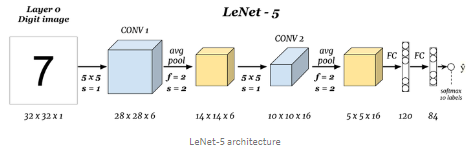



Começamos com uma imagem em escala de cinza (o LeNet-5 foi treinado em imagens em escala de cinza), com um formato de 32x32 x1. Na primeira etapa, usamos um conjunto de seis filtros 5x5 com um passo de um. Como usamos seis filtros, acabamos com um formato de 28x28x6 e um passo de um e sem preenchimento.

A saída é calculada da seguinte forma:

    (n +2p -f )/ s +1 * (n +2p -f )/ s +1 * Nc

onde:

Nc -> numero de canais -> número de filtros usados para convolucionar nossas entradas.

p -> padding -> Na LeNet-5 não utilizamos padding

f -> tamanho filtro convolucional

s -> stride 

    (n +2p -f )/ s +1 * (n +2p -f )/ s +1 * Nc
    = (32+0–5)/1 +1 * (32+0–5)/1 +1 * 6
    = 28 * 28 * 6

Na época em que o artigo foi publicado, as pessoas usavam o avg pooling muito mais do que o max pooling.

Utilizaremos Tensorflow 2 para montar nossa rede neural seguindo os seguintes passos:
  - Baixar o conjunto de dados MNIST com imagens manuscritas rotuladas (28x28 px).
  - Preprocessar o conjunto de dados para adequa-lo as entradas da rede  ( 32 x 32 px)
  - Construir nosso modelo (arquitetura de rede LeNet-5).
  - A etapa final seria treinar nosso modelo e, em seguida, testar e validar o desempenho.

## Importando bibiliotecas

In [1]:
%tensorflow_version 2.x
%matplotlib inline

from requests import get
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from time import time
import seaborn as sns


TensorFlow 2.x selected.


## Baixando o conjunto de dados

Os dados podem ser baixados do site, http://yann.lecun.com/exdb/mnist/: 
  - conjunto de imagens de treino: train-images-idx3-ubyte.gz (9912422 bytes)
  - conjunto de labels de treino: train-labels-idx1-ubyte.gz (28881 bytes)
  - conjunto de imagens de teste: t10k-images-idx3-ubyte.gz (1648877 bytes)
  - conjunto de labels de teste: t10k-labels-idx1-ubyte.gz (4542 bytes)

In [0]:
def download_file(url, file_name):
    with open(file_name, "wb") as file:
        response = get(url)
        file.write(response.content)

download_file('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')        

## Carregando os dados

In [0]:
def read_mnist(images_path: str, labels_path: str):
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)
        
    return features, labels

train = {}
test = {}

train['features'], train['labels'] = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = read_mnist('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')    

## Explorando os dados

É sempre bom fazer uma exploração de dados antes de começarmos a usá-lo, encontrar discrepâncias e decidir se precisamos de uma fase de pré-processamento para uniformizá-los ou aumentá-los. E também para garantir que todas as classes sejam cobertas por mais ou menos o mesmo número de amostras.

In [4]:
print('# imagens de treino:', train['features'].shape[0])
print('# imagens de teste:', test['features'].shape[0])

# imagens de treino: 60000
# imagens de teste: 10000


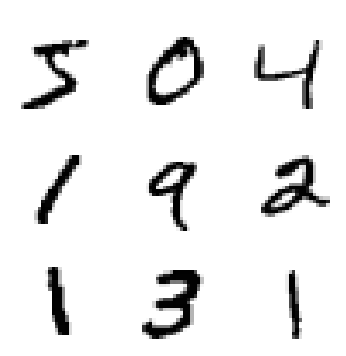

In [5]:
def display_image(position):
    image = train['features'][position].squeeze()
    plt.subplot(3, 3, position + 1)
    plt.axis('off')
    plt.title('Label: %d' % (train['labels'][position]), color='white')
    plt.imshow(image, cmap=plt.cm.gray_r)

plt.figure(figsize=(6, 6))
for i in range(9):
  display_image(i)
plt.show();

## Distribuição dos exemplos de treino

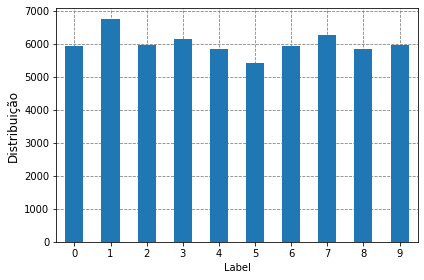

In [6]:
train_labels_count = np.unique(train['labels'], return_counts=True)
df = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
ax = df.plot(x ='Label', y='Count', kind = 'bar', rot=0, legend=False )
ax.set_ylabel("Distribuição", fontsize=12)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.tight_layout();

## Separando dados ente validacao e treino

In [7]:
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

print('# imagens de treino:', train['features'].shape[0])
print('# imagens de validacao:', validation['features'].shape[0])


# imagens de treino: 48000
# imagens de validacao: 12000


## Preparando dados de entrada

A arquitetura LeNet-5 aceita imagens de 32x32 pixels como entrada; os dados MNIST são 28x28 pixels. Simplesmente preenchemos as imagens com zeros para superar isso.

In [8]:
train['features']      = np.pad(train['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
validation['features'] = np.pad(validation['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
test['features']       = np.pad(test['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Tamanho atualizado: {}".format(train['features'][0].shape))

Tamanho atualizado: (32, 32, 1)


## Implementando a rede



**Inspirado em ** https://github.com/udacity/CarND-LeNet-Lab/blob/master/LeNet-Lab-Solution.ipynb

#### Entrada
    Imagem 32x32x1 pixels 

#### Arquitetura
* **Convolutional #1** saída 28x28x6
    * **Activation** qualquer função de ativatição function, utilizaremos `relu`

* **Pooling #1** A saída deve ser 14x14x6.

* **Convolutional #2** saída 10x10x16.
    * **Activation** qualquer função de ativatição function, utilizaremos `relu`

* **Pooling #2** saída 5x5x16.
    * **Flatten** Serializa a saía da ultima camanda de pooling

* **Fully Connected #1** saida 120
    * **Activation** qualquer função de ativatição function, utilizaremos `relu`

* **Fully Connected #2** outputs 84
    * **Activation** qualquer função de ativatição function, utilizaremos `relu`

* **Fully Connected (Logits) #3** saída 10


In [9]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)))
model.add(tf.keras.layers.AveragePooling2D())
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.AveragePooling2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=120, activation='relu'))
model.add(tf.keras.layers.Dense(units=84, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [0]:
EPOCHS = 10
BATCH_SIZE = 128

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

X_train, y_train = train['features'], tf.keras.utils.to_categorical(train['labels'])
X_validation, y_validation = validation['features'], tf.keras.utils.to_categorical(validation['labels'])

train_generator = tf.keras.preprocessing.image.ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = tf.keras.preprocessing.image.ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)

## Treinamento

In [11]:
print('# imagens de treino:', train['features'].shape[0])
print('# imagens de validacao:', validation['features'].shape[0])

steps_per_epoch = X_train.shape[0] // BATCH_SIZE
validation_steps = X_validation.shape[0] // BATCH_SIZE

tensorboard = tf.keras.callbacks.TensorBoard(log_dir="./logs/{}".format(time()))

model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
          validation_data=validation_generator, validation_steps=validation_steps, 
          shuffle=True, callbacks=[tensorboard])

# imagens de treino: 48000
# imagens de validacao: 12000
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 375 steps, validate for 93 steps
Epoch 1/10
375/375 [==============================] - 10s 27ms/step - loss: 0.6091 - accuracy: 0.8961 - val_loss: 0.1139 - val_accuracy: 0.9680
Epoch 2/10
375/375 [==============================] - 2s 7ms/step - loss: 0.0881 - accuracy: 0.9737 - val_loss: 0.0782 - val_accuracy: 0.9765
Epoch 3/10
375/375 [==============================] - 2s 7ms/step - loss: 0.0633 - accuracy: 0.9805 - val_loss: 0.0744 - val_accuracy: 0.9771
Epoch 4/10
375/375 [==============================] - 3s 7ms/step - loss: 0.0442 - accuracy: 0.9861 - val_loss: 0.0802 - val_accuracy: 0.9777
Epoch 5/10
375/375 [==============================] - 3s 7ms/step - loss: 0.0397 - accuracy: 0.9875 - val_loss: 0.0499 - val_accuracy: 0.9837
Epoch 6/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0314 - accuracy: 0.9896 - val_loss: 0.0524 - val_accuracy: 0.9

## Testando o modelo



In [12]:
score = model.evaluate(test['features'], tf.keras.utils.to_categorical(test['labels']))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 94us/sample - loss: 0.0519 - accuracy: 0.9853
Test loss: 0.05192004582037625
Test accuracy: 0.9853


## Salvando o modelo


In [0]:
model.save('mnist_model.h5')

# Servindo Tensorboard

## Baixando ngrok

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

## Iniciando tunel

In [37]:
get_ipython().system_raw('./ngrok http 6006 &')

ngrok_url = !curl -s http://localhost:4040/api/tunnels | python -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
        
ngrok_url = ngrok_url[0].replace("'", '')
print(ngrok_url)

https://9c183e89.ngrok.io


## Iniciando Tensorboard

In [39]:
# O correto era os comandos comentados, mas não tá funcionando 
#get_ipython().system_raw('!tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format('./logs'))
#from IPython.display import IFrame
#IFrame(ngrok_url, width=700, height=900)

# Este comando vai travar a pagina
!tensorboard --logdir logs --host 0.0.0.0 --port 6006

TensorBoard 2.1.1 at http://0.0.0.0:6006/ (Press CTRL+C to quit)
^C
